In [125]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.layers import (
    Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Rescaling, Input
) 
from keras.models import Sequential
# tensorflow 
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

# utils 
import numpy as np 
import random 

# vis
# import seaborn as sns
import cv2 
import matplotlib.pyplot as plt


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


In [126]:
# load data from directory

In [127]:
img_size = (150, 150)

def img_to_tf_dataset(path, labels='inferred', img_size=img_size, subset="training"):
    """ Fetch images assign label to them based on folders tree"""
    dataset = image_dataset_from_directory(
        directory=path,
        labels=labels , # labels generated from folder structure
        image_size=img_size,
        validation_split=0.2,
        subset=subset,
        seed=123,
        # default batch size 32
    )
    return dataset

In [128]:
train_ds = img_to_tf_dataset('data')

Found 644 files belonging to 2 classes.
Using 516 files for training.


In [129]:
val_ds = img_to_tf_dataset('data', subset='validation')

Found 644 files belonging to 2 classes.
Using 128 files for validation.


In [130]:
NUM_CLS = len(val_ds.class_names)
CLS_NAMES = val_ds.class_names
CLS_NAMES

['0', '1']

In [131]:
sample = val_ds.take(1).shuffle(1)
sample

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

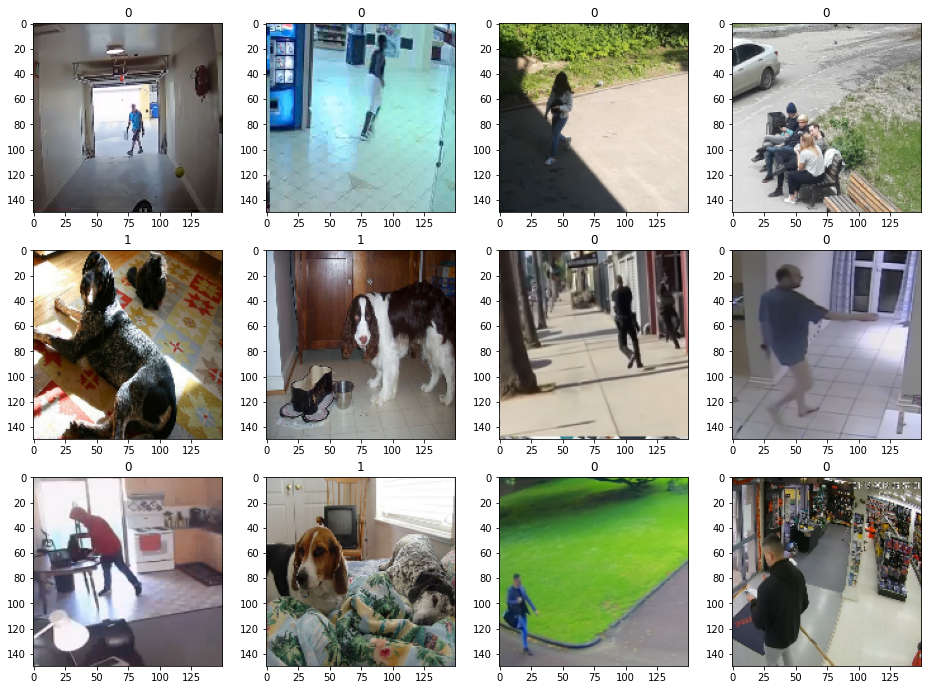

In [132]:
# plot 12 images from the training set with thier  class names
plt.figure(figsize=(16,16))
for img, labels in train_ds.take(1):
    for i in range(12):
        x = plt.subplot(4, 4, i + 1 )
        # tf.Tensor ( data set)
        im = img[i].numpy().astype('uint8') # cast to unit8 type without losing much pixels
        plt.imshow(im)
        class_name = train_ds.class_names[labels[i]]
        plt.title(class_name)

In [133]:
train_ds = train_ds.shuffle(100)
val_ds = val_ds.shuffle(100)

In [134]:
train_ds = train_ds.map(lambda x, y: (Rescaling(1./255)(x), y))
val_ds = val_ds.map(lambda x, y: (Rescaling(1./255)(x), y))

In [135]:
model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(150,150,3),
                   pooling='avg',classes=NUM_CLS,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)

In [136]:
model.add(Flatten())
model.add(Dense(128, activation='selu'))
model.add(Dense(NUM_CLS, activation='sigmoid'))

In [137]:

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = "adam",
    metrics=['accuracy'],
)

In [138]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
17/17 [==============================] - 20s 1s/step - loss: 0.4722 - accuracy: 0.8004 - val_loss: 0.3395 - val_accuracy: 0.8672
Epoch 2/10
17/17 [==============================] - 19s 1s/step - loss: 0.1822 - accuracy: 0.9360 - val_loss: 0.2433 - val_accuracy: 0.9219
Epoch 3/10
17/17 [==============================] - 20s 1s/step - loss: 0.1394 - accuracy: 0.9535 - val_loss: 0.2235 - val_accuracy: 0.9219
Epoch 4/10
17/17 [==============================] - 21s 1s/step - loss: 0.1198 - accuracy: 0.9632 - val_loss: 0.2122 - val_accuracy: 0.9297
Epoch 5/10
17/17 [==============================] - 21s 1s/step - loss: 0.1082 - accuracy: 0.9632 - val_loss: 0.2045 - val_accuracy: 0.9297
Epoch 6/10
17/17 [==============================] - 21s 1s/step - loss: 0.1005 - accuracy: 0.9632 - val_loss: 0.2151 - val_accuracy: 0.9297
Epoch 7/10
17/17 [==============================] - 21s 1s/step - loss: 0.0866 - accuracy: 0.9709 - val_loss: 0.1965 - val_accuracy: 0.9219
Epoch 8/10
17/17 [==

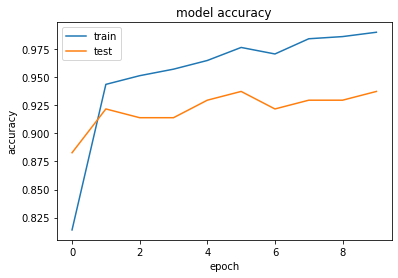

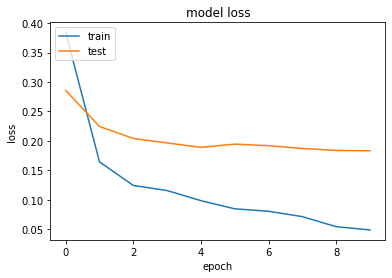

In [60]:
# plot history 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [121]:
from keras.applications import mobilenet_v2
from keras.preprocessing import image


def prepare_image(img_path):

    img = image.load_img(img_path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = mobilenet_v2.preprocess_input(x)
    return x
x = prepare_image('test/7.jpg') 

In [122]:
p = model.predict(x)

In [123]:
def get_class_name(pred):
    classes_vals = pred.tolist()[0]
    hashtable = {}
    for i,j in zip(classes_vals, CLS_NAMES):
        hashtable[j] = i
    return hashtable

In [124]:
get_class_name(p)

{'0': 0.49818697571754456, '1': 0.634186863899231}

In [94]:
# save model 
model.save('dog.h5')

In [35]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('dog.h5')

In [36]:
new_model.predict(x)

array([[0.9667846, 0.0537034]], dtype=float32)